<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# check pytorch version
import torch
print(torch.__version__)

2.2.1+cu121


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model Simulation

模型架構圖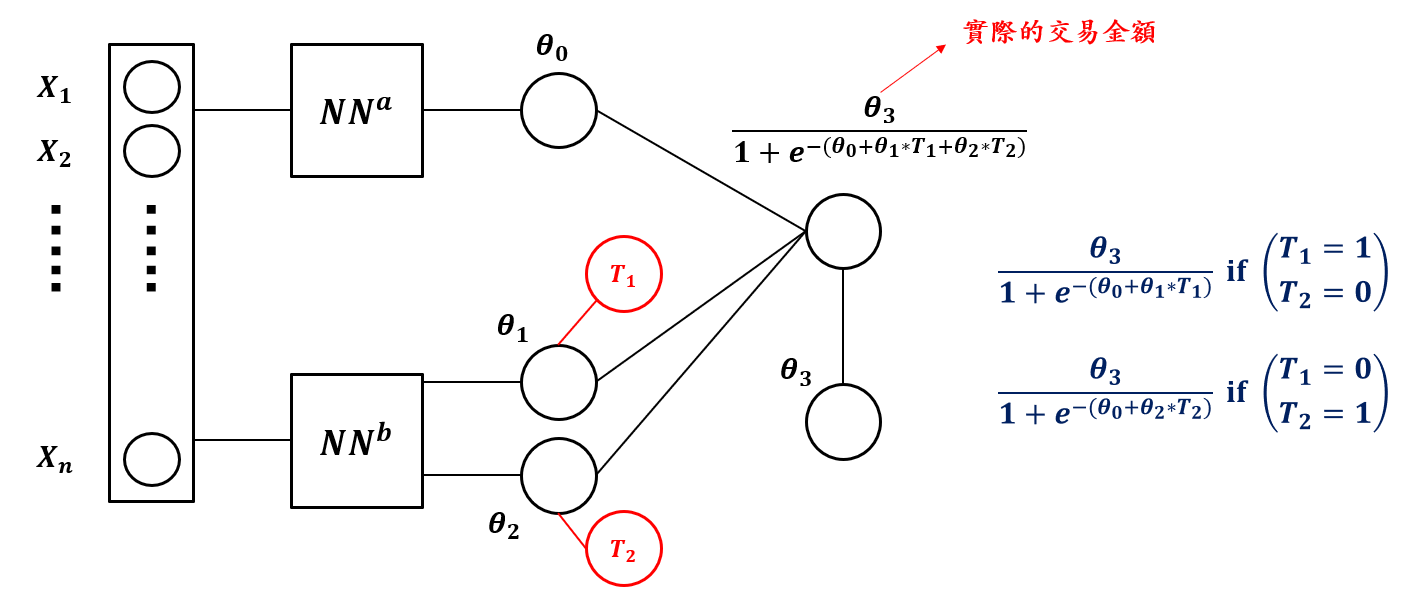

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,F1711372040,42,0,1.0,0,364.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
1,Y2722357310,50,0,2.0,0,2429.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
2,N2738280700,35,0,2.0,0,0.0,1,0,0,6,...,0,0,0,1,0,0,0,1,0,0
3,N1798657360,49,0,1.0,0,420.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
4,T1294962440,69,0,1.0,0,1000.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218585,E1777416360,49,0,1.0,0,0.0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
218586,F1735467240,45,0,1.0,0,0.0,1,3,0,3,...,0,0,0,0,0,1,0,0,0,0
218587,E2789752690,8,0,2.0,0,100.0,1,0,0,3,...,0,0,0,0,0,1,0,0,0,0
218588,B2774924650,26,0,2.0,0,0.0,1,2,0,3,...,0,0,0,0,0,1,0,0,0,0


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.drop(['UNINO'], axis = 1, inplace = True)
test.drop(['UNINO'], axis = 1, inplace = True)
print(train.shape, test.shape)

(174872, 204) (43718, 204)


In [35]:
df.iloc[:,150]

0         0
1         0
2         0
3         0
4         0
         ..
218585    0
218586    0
218587    0
218588    0
218589    0
Name: 換匯發送名單, Length: 218590, dtype: int64

In [57]:
import torch
import torch.nn as nn

class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        self.fc1_branch1 = nn.Linear(input_size, 1)  # Branch 1 with 1 neuron
        self.fc1_branch2 = nn.Linear(input_size, 2)  # Branch 2 with 2 neurons
        self.fc2 = nn.Linear(3, 1)  # Hidden layer with 1 neuron, merging both branch outputs

    def forward(self, x):
        # Branch 1
        x_branch1 = torch.sigmoid(self.fc1_branch1(x))  # Using all input features for Branch 1

        # Branch 2
        x_branch2 = torch.sigmoid(self.fc1_branch2(x))  # Using all input features for Branch 2
        T1 = x[:, 150].unsqueeze(1)  # Assuming the first feature is used to multiply with the first neuron in Branch 2
        T2 = 1-T1  # Assuming the second feature is used to multiply with the second neuron in Branch 2

        # Element-wise multiplication with the corresponding feature
        T1_multiplied = x_branch2[:, 0].unsqueeze(1) * T1  # Multiply the first neuron with the first feature
        T2_multiplied = x_branch2[:, 1].unsqueeze(1) * T2  # Multiply the second neuron with the second feature

        # Concatenate both branches with the multiplied tensors
        x_concat = torch.cat((x_branch1, T1_multiplied, T2_multiplied), dim=1)

        # Hidden layer
        x_hidden = torch.sigmoid(self.fc2(x_concat))

        # Output layer
        output = torch.sigmoid(x_hidden)
        return output

# Example usage
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Print model architecture
print(model)

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=2, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim

train_data = torch.tensor(train.values, dtype=torch.float32)

# If you have labels (target variable) in your DataFrame, you can separate them
# For example, if the last column is the target variable
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_tensor = torch.tensor(train['跨售行為'].values)  # Last column as the target variable

# Define the model
input_size = 202 # Number of input features including T1
model = CustomNet(input_size)

# Define the loss function #Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100000  # Number of epochs
desired_loss = 0.5  # Desired loss threshold

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor.float())  # Convert T1_train to float

    # Compute loss
    loss = criterion(outputs.squeeze(), y_tensor.float())  # Ensure y_tensor is of float type

    # Zero gradients, backward pass, and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Check if the loss is below the desired threshold
    if loss.item() < desired_loss:
        print(f'Loss reached the desired threshold of {desired_loss}. Stopping training...')
        break

Streaming output truncated to the last 5000 lines.
Epoch [28102/100000], Loss: 0.6946
Epoch [28103/100000], Loss: 0.6946
Epoch [28104/100000], Loss: 0.6946
Epoch [28105/100000], Loss: 0.6946
Epoch [28106/100000], Loss: 0.6946
Epoch [28107/100000], Loss: 0.6946
Epoch [28108/100000], Loss: 0.6946
Epoch [28109/100000], Loss: 0.6946
Epoch [28110/100000], Loss: 0.6946
Epoch [28111/100000], Loss: 0.6946
Epoch [28112/100000], Loss: 0.6946
Epoch [28113/100000], Loss: 0.6946
Epoch [28114/100000], Loss: 0.6946
Epoch [28115/100000], Loss: 0.6946
Epoch [28116/100000], Loss: 0.6946
Epoch [28117/100000], Loss: 0.6946
Epoch [28118/100000], Loss: 0.6946
Epoch [28119/100000], Loss: 0.6946
Epoch [28120/100000], Loss: 0.6946
Epoch [28121/100000], Loss: 0.6946
Epoch [28122/100000], Loss: 0.6946
Epoch [28123/100000], Loss: 0.6946
Epoch [28124/100000], Loss: 0.6946
Epoch [28125/100000], Loss: 0.6946
Epoch [28126/100000], Loss: 0.6946
Epoch [28127/100000], Loss: 0.6946
Epoch [28128/100000], Loss: 0.6946
Epoc

KeyboardInterrupt: 

In [59]:
# Prediction
# Assuming you have your test input data X_test in a tensor
test_data = torch.tensor(test.values, dtype=torch.float32)

X_test = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_test = torch.tensor(test['跨售行為'].values)  # Last column as the target variable


# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_test.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_test.float())
print("Test Loss:", loss_test.item())

# Compute accuracy or other metrics if needed
# For example, for binary classification, you can calculate accuracy
predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary predictions
accuracy = (predicted_labels == y_test).float().mean().item()
print("Accuracy:", accuracy)

Predictions: [[0.50050646]
 [0.50041145]
 [0.50046504]
 ...
 [0.5004536 ]
 [0.50047207]
 [0.50050545]]
Test Loss: 0.6943620443344116
Accuracy: 0.0024703782983124256


In [54]:
len(test)
#43718

43718